In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

import tqdm

from pprint import pprint

In [14]:
net    =  nn.Sequential(nn.Linear(2, 50), nn.Tanh(),
                        nn.Linear(50, 2), nn.Tanh(), nn.Linear(2, 2))

opt    = optim.Adam(net.parameters(), lr=0.001)

d      = 0.1
x, y   = torch.arange(0, 1 + d / 2, d), torch.arange(0, 1 + d / 2, d)
X, Y   = torch.meshgrid((x, y))
grid   = torch.stack((X.flatten(), Y.flatten())).transpose(1, 0)

X_, Y_ = torch.meshgrid((x[1:-1], y[1:-1]))
ingrd  = torch.stack((X_.flatten(), Y_.flatten())).transpose(1, 0)
n = x.shape[0]

E, nu = 1, 0.15
mu    = E / (2 + 2 * nu)
lamb  = (E * nu) / ((1 + nu) * (1 - 2 * nu))

In [15]:
bounds = {
    'x': {
        'l': {
            'var_ind': 1,
            'value'  : 0,
            'values' : x,
            'func'   : lambda _x: torch.ones_like(_x, requires_grad=True) * torch.tensor([[0.0, 0.0]]),
            'grid'   : grid[:n]
        },
        'r': {
            'var_ind': 1,
            'value'  : 1,
            'values' : x,
            'func'   : lambda _x: torch.ones_like(_x, requires_grad=True) * torch.tensor([[0.0, 0.0]]),
            'grid'   : grid[-n:]
        }
    },
    'y': {
        'l': {
            'var_ind': 0,
            'value'  : 0,
            'values' : y,
            'func'   : lambda _y: torch.ones_like(_y, requires_grad=True) * torch.tensor([[0.0, 0.0]]),
            'grid'   : grid[::n]
        },
        'r': {
            'var_ind': 0,
            'value'  : 1,
            'values' : y,
            'func'   : lambda _y: torch.ones_like(_y, requires_grad=True) * torch.tensor([[0.0, 0.0]]),
            'grid'   : grid[n - 1::n]
        }
    }
}

In [16]:
DX, DY = torch.tensor([d, 0.0]), torch.tensor([0.0, d])
errors = list()
epochs = 500
plot   = True

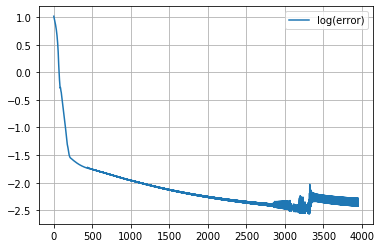

100%|██████████| 500/500 [00:04<00:00, 101.38it/s]


In [28]:
for epoch in tqdm.tqdm(range(epochs)):
    
    opt.zero_grad()
    loss = 0
    
#     ingrd = grid
    
    x_lower, x_left, x_cent, x_right, x_upper = grid - DX - DY, grid - DX, grid, grid + DX, grid + DX + DY
    y_lower, y_left, y_cent, y_right, y_upper = grid - DX - DY, grid - DY, grid, grid + DY, grid + DX + DY
    
    UV_x_lower, UV_x_left, UV_x_cent, UV_x_right, UV_x_upper = net(x_lower), net(x_left), net(x_cent), net(x_right), net(x_upper)
    UV_y_lower, UV_y_left, UV_y_cent, UV_y_right, UV_y_upper = net(y_lower), net(y_left), net(y_cent), net(y_right), net(y_upper)
    
    U_x_lower, U_x_left, U_x_cent, U_x_right, U_x_upper = UV_x_lower[:, 0][:, None], UV_x_left[:, 0][:, None], UV_x_cent[:, 0][:, None], UV_x_right[:, 0][:, None], UV_x_upper[:, 0][:, None]
    V_x_lower, V_x_left, V_x_cent, V_x_right, V_x_upper = UV_x_lower[:, 1][:, None], UV_x_left[:, 1][:, None], UV_x_cent[:, 1][:, None], UV_x_right[:, 1][:, None], UV_x_upper[:, 1][:, None]
    U_y_lower, U_y_left, U_y_cent, U_y_right, U_y_upper = UV_y_lower[:, 0][:, None], UV_y_left[:, 0][:, None], UV_y_cent[:, 0][:, None], UV_y_right[:, 0][:, None], UV_y_upper[:, 0][:, None]
    V_y_lower, V_y_left, V_y_cent, V_y_right, V_y_upper = UV_y_lower[:, 1][:, None], UV_y_left[:, 1][:, None], UV_y_cent[:, 1][:, None], UV_y_right[:, 1][:, None], UV_y_upper[:, 1][:, None]
    
    dU_2_dx_2 = (U_x_right - 2 * U_x_cent + U_x_left) / (d ** 2)
    dV_2_dx_2 = (V_x_right - 2 * V_x_cent + V_x_left) / (d ** 2)
    
    dU_2_dy_2 = (U_y_right - 2 * U_y_cent + U_y_left) / (d ** 2)
    dV_2_dy_2 = (V_y_right - 2 * V_y_cent + V_y_left) / (d ** 2)
    
    dU_2_dxdy = (U_x_upper - U_y_right - U_x_right + U_x_cent) / (d ** 2)
    dV_2_dxdy = (V_x_upper - V_y_right - V_x_right + V_x_cent) / (d ** 2)
    
    laplacian_U = dU_2_dx_2 + dU_2_dy_2
    laplacian_V = dV_2_dx_2 + dV_2_dy_2
    
    eq1 = (mu + lamb) * (dU_2_dx_2 + dV_2_dxdy) + mu * laplacian_U
    eq2 = (mu + lamb) * (dU_2_dxdy + dV_2_dy_2) + mu * laplacian_V
    
    l1    = ((eq1 ** 2 + eq2 ** 2) ** 2).sum() / dV_2_dxdy.shape[0]
    l2    = 0.0
    
    count = 0
    for var_name, var_bounds in bounds.items():
        for var_bound, bound_info in var_bounds.items():
            var_ind = bound_info['var_ind']
            var_vls = bound_info['values']
            var_fun = bound_info['func']
            var_grd = bound_info['grid']
            
            l2 +=  (torch.norm(net(var_grd) - var_fun(var_grd), dim=0)).sum()
            count += var_vls.shape[0]
            
#     l2 = l2
    loss = l1 + l2
    
    loss.backward()
    opt.step()
    
    errors += [(l1 + l2).item()]
    
    if plot and epoch % 50 == 0:
        
        clear_output()
        
        plt.plot(np.log10(np.array(errors)), label='log(error)')
        plt.legend()
        plt.grid()
        plt.show()
        
#         UV = net(ingrd)
#         U = torch.reshape(UV[:, 0], X.shape).detach().numpy()
#         V = torch.reshape(UV[:, 1], X.shape).detach().numpy()

#         plt.contourf(X, Y, U, 25, cmap='inferno')
#         plt.colorbar()
#         plt.show()
        
#         plt.contourf(X, Y, V, 25, cmap='inferno')
#         plt.colorbar()
#         plt.show()

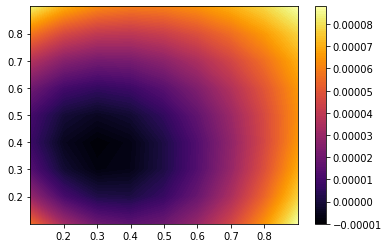

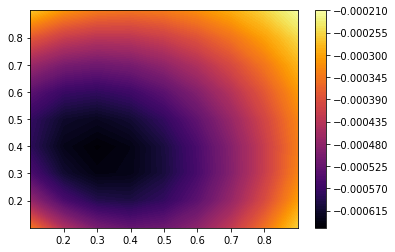

In [25]:
UV = net(ingrd)
U = torch.reshape(UV[:, 0], X_.shape).detach().numpy()
V = torch.reshape(UV[:, 1], X_.shape).detach().numpy()

plt.contourf(X_, Y_, U, 100, cmap='inferno')
plt.colorbar()
plt.show()

plt.contourf(X_, Y_, V, 100, cmap='inferno')
plt.colorbar()
plt.show()

In [26]:
torch.abs(net(bounds['x']['l']['grid']) - bounds['x']['l']['func'](bounds['y']['l']['grid'])).max()

tensor(0.0005, grad_fn=<MaxBackward1>)

In [27]:
net(bounds['x']['l']['grid']) - bounds['x']['l']['func'](bounds['y']['l']['grid'])

tensor([[ 1.3551e-04,  2.0057e-05],
        [ 9.1180e-05, -1.9616e-04],
        [ 5.9575e-05, -3.5062e-04],
        [ 3.9715e-05, -4.4909e-04],
        [ 3.0544e-05, -4.9749e-04],
        [ 3.0942e-05, -5.0178e-04],
        [ 3.9741e-05, -4.6808e-04],
        [ 5.5760e-05, -4.0224e-04],
        [ 7.7829e-05, -3.0985e-04],
        [ 1.0486e-04, -1.9616e-04],
        [ 1.3583e-04, -6.5893e-05]], grad_fn=<SubBackward0>)